# FULL DATA INTERPRETATION

### In this notebook I´ll apply the code that I tested in the Initial Data interpretation notebook, with the whole dataset 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:.2f}'.format #So the numbers will not appear in a scientific format

- Concatenation of the 3 datasets that shows the data of the last 12 months, from September 2019 to September 2020. 



In [5]:
chunk1=pd.read_csv("Data from September 2019 to October 2019.csv", thousands='.',parse_dates=['Time'])
chunk2=pd.read_csv("Data From October 2019 to Jan 2020.csv", thousands='.',parse_dates=['Time'])
chunk3=pd.read_csv("Data From Jan to April 2020.csv", thousands='.',parse_dates=['Time'])
chunk4=pd.read_csv("Data From April to July 2020.csv", thousands='.',parse_dates=['Time'])
chunk5=pd.read_csv("Data from July 2020 to September 2020.csv", thousands='.',parse_dates=['Time'])
print(chunk1.shape, chunk2.shape, chunk3.shape, chunk4.shape,chunk5.shape)

(99215, 22) (185523, 22) (222676, 22) (241940, 22) (170071, 22)


In [30]:
data = pd.concat([chunk1,chunk2,chunk3,chunk4,chunk5])
data.shape

(919425, 22)

In [7]:
data.isnull().sum()

Time                                     0
Domain                                 366
Opportunities                            0
Format Loads                         50354
Format Fill Rate                     50354
Impressions                              0
Viewable Impressions                     0
Viewability Measured Impressions         0
Viewability Rate                    479243
Fill Rate                                0
Efficiency Rate                          0
CPM                                      0
Cost                                     0
Profit                                   0
Revenue                                  0
Profit Margin                            0
Clicks                                   0
CTR                                      0
25% View Rate                            0
50% View Rate                            0
75% View Rate                            0
100% View Rate                           0
dtype: int64

I drop all the Domains that don´t have info about the format Loads and the Domain. With the filters I´ll apply later the
Null values of the Viewability Rate will be rejected

In [31]:
data = data.dropna(subset =['Format Loads','Format Fill Rate', 'Domain'])

- 1: Dropping the columns that don´t add value to the advertisers
- 2: Converting numeric columns with ' , ' into integers
- 3: Converting columns with '%' , '$' and ',' into floats

In [32]:
#1
data.drop(['Opportunities','Viewable Impressions','Viewability Measured Impressions','Fill Rate', 'Cost','Profit',
           'Revenue','Profit Margin'],axis=1, inplace=True)

#2
data['Format Loads'] = data['Format Loads'].str.replace(",", "").astype(int)
data['Impressions'] = data['Impressions'].str.replace(",", "").astype(int)
data['Clicks'] = data['Clicks'].str.replace(",", "").astype(int)

#3
data['Format Fill Rate'] = data['Format Fill Rate'].str.replace("%", "").astype(float)
data['Viewability Rate'] = data['Viewability Rate'].str.replace("%", "").astype(float).fillna(0)
data['Efficiency Rate'] = data['Efficiency Rate'].str.replace("%", "").astype(float)
data['CPM'] = data['CPM'].str.replace("$", "").astype(float)
data['CTR'] = data['CTR'].str.replace("%", "").astype(float)
data['25% View Rate'] = data['25% View Rate'].str.replace("%", "").astype(float)
data['50% View Rate'] = data['50% View Rate'].str.replace("%", "").astype(float)
data['75% View Rate'] = data['75% View Rate'].str.replace("%", "").astype(float)
data['100% View Rate'] = data['100% View Rate'].str.replace("%", "").astype(float)

In [10]:
data.isnull().sum()

Time                0
Domain              0
Format Loads        0
Format Fill Rate    0
Impressions         0
Viewability Rate    0
Efficiency Rate     0
CPM                 0
Clicks              0
CTR                 0
25% View Rate       0
50% View Rate       0
75% View Rate       0
100% View Rate      0
dtype: int64

In [11]:
print(len(data['Domain'].unique()))
print(data.shape)


29046
(868705, 14)


- **We have 29046 Domains, but as we´ll see later, there are a lot of residuals domains that I´ll filter**

## DATAFRAME GROUPBY_DOMAINS

- **I´m going to create a new DataFrame grouping by Domain, and calculating the mean of each variable based on the daily data of the last 12 months. This is de DataFrame that I´ll use later to apply clustering, and divide the Domains into different groups.**

In [33]:
groupby_domains = data.groupby(['Domain']).agg({'Format Loads':np.mean,
                                'Impressions':np.mean,
                                'Format Fill Rate':np.mean,
                                'Viewability Rate':np.mean,
                                'Efficiency Rate':np.mean,
                                'CPM':np.mean,
                                'Clicks':np.mean,
                                'CTR':np.mean,
                                '25% View Rate':np.mean,
                                '50% View Rate':np.mean,
                                '75% View Rate':np.mean,
                                '100% View Rate':np.mean
                                }).sort_values( by= 'Format Loads',ascending=False).reset_index()
print(groupby_domains.shape)

(29046, 13)


### **I´ll keep the domains with a mean of more than 30000 Format Loads. It´s the filter to consider a domain representative and the way to drop the residuals**


In [34]:
groupby_domains = groupby_domains[groupby_domains['Format Loads']>30000]
print(groupby_domains.shape)

(734, 13)


In [35]:
# Keeping in the data DF only the 734 domains selected
domains_filtered = groupby_domains['Domain']
data = data.merge(domains_filtered, on='Domain',how='inner',right_index=True ).reset_index(drop=True)
print(len(data['Domain'].unique()))


734


**After this basic filtering, we keep the 734 domains that I am going to work with**

# NEW VARIABLES

### ***ADDING A COLUMN TO REPRESENT THE RECURRENCE OF THE DOMAIN***

We have 12 months available, 366 days. Of course it´s not the same a Domain with great rates which is available only 20 days, that  a Domain with the same rates but available 50% or 80% of the days, so I´m gonna represent this with a percentage: available days divided by the total of days



In [36]:
#Creating a Dataframe with the number of days that each domain appears
recurrence = pd.DataFrame(data['Domain'].value_counts()).reset_index()
recurrence.columns = ['Domain', 'Recurrence']

#List comprehension to assign the levels based on the number of days
recurrence['Domain Recurrence'] = [(x/366)*100 for x in recurrence['Recurrence']]
recurrence = recurrence[['Domain', 'Domain Recurrence']]

#Adding the column to the main Dataframe
data = data.merge(recurrence, on='Domain', how='left').set_index('Time') 
groupby_domains = groupby_domains.merge(recurrence, on='Domain', how='left')

### ***ADDING THE CATEGORY OF THE DOMAIN THROUGH A NEW TABLE***

In [37]:
categories = pd.read_csv('Index Exchange Quality Inventory Mapping - Existing Acccount-Reseller-Domains - Compliance (1).csv')
categories.columns = ['Unnamed: 0', 'Partner/Seller Name', 'Partner/Seller ID',
       'Inventory Relationship\n(select from dropdown)', 'Domain',
       'Category', 'Monthly Volume', 'Ad Formats',
       'Banner/Player Dimensions']

print(len(categories['Category'].unique()), 'categories')

import re
pattern = '>'
renamed_categories = []
for string in categories['Category']:
    text = string
    match = re.search(pattern, text)
    s = match.start()
    renamed_categories.append(string[:s])
categories['Category'] = categories['Category'].replace(categories['Category'].values, renamed_categories )
categories['Category'] = categories['Category'].map(lambda x: x.strip()) # to reomve the blank space in the end of the strings

print(len(categories['Category'].unique()))

52 categories
19


In [38]:
categories_importance = pd.DataFrame(categories.groupby('Category')['Monthly Volume'].sum().sort_values(ascending=False).reset_index())

total_formatloads = categories_importance['Monthly Volume'].sum()
categories_importance['Category importance'] = categories_importance['Monthly Volume'].apply(lambda x: (x/total_formatloads)*100)

domains_categories_importance = categories.merge(categories_importance, on='Category')
domains_categories_importance = domains_categories_importance[['Domain','Category','Category importance']]

In [39]:
groupby_domains.merge(domains_categories_importance, on='Domain', how ='left').isnull().sum()

Domain                   0
Format Loads             0
Impressions              0
Format Fill Rate         0
Viewability Rate         0
Efficiency Rate          0
CPM                      0
Clicks                   0
CTR                      0
25% View Rate            0
50% View Rate            0
75% View Rate            0
100% View Rate           0
Domain Recurrence        0
Category               378
Category importance    378
dtype: int64

In [40]:
category_nans = groupby_domains.merge(domains_categories_importance, on='Domain', how ='left')
category_nans = category_nans[category_nans['Category'].isnull()][['Domain','Category']]
category_nans.to_csv('Category_NANS.csv')

### **The new table is not updated and there are 378 domains that are not on it. I consider the Category column could add value to the final model, so I don´t want NANs on it. Because of that I´m gonna manually introduce the category in the Domains without it to have this column filled, and then I´ll merge this with the main DataFrames**

- 1: Reading the dataframe with the Nans manually added
- 2: Adding to this dataframe the category importance columns
- 3: Merging with the dataframe with the domains that didn´t have null category

In [41]:
#1 
groupby_domains_NANs_corrected = pd.read_csv('Category_NANS_corrected.csv')
groupby_domains_NANs_corrected.drop('Unnamed: 0', axis=1, inplace=True)

#2
groupby_domains_NANs_corrected = groupby_domains_NANs_corrected.merge(categories_importance, on='Category')
groupby_domains_NANs_corrected = groupby_domains_NANs_corrected[['Domain','Category','Category importance']]

#3
categories_by_importance_complete = domains_categories_importance.merge(groupby_domains_NANs_corrected, how = 'outer')


In [42]:
data = data.reset_index().merge(categories_by_importance_complete, on='Domain', how='left').set_index('Time')
display(data.head(5))
data.isnull().sum()


,Domain,Format Loads,Format Fill Rate,Impressions,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,25% View Rate,50% View Rate,75% View Rate,100% View Rate,Domain Recurrence,Category,Category importance
Time,,,,,,,,,,,,,,,,
2019-09-01,dagens.dk,5701,9.61,548,88.68,73.07,1.76,5,0.91,79.74,66.42,56.02,50.36,31.69,News & Portals,58.61
2019-09-02,dagens.dk,5513,12.72,701,87.77,84.66,1.84,7,1.00,78.17,65.62,55.06,47.36,31.69,News & Portals,58.61
2019-09-03,dagens.dk,19425,27.60,5361,91.82,94.07,1.96,35,0.65,88.68,79.61,73.83,68.83,31.69,News & Portals,58.61
2019-10-01,dagens.dk,2,0.00,0,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,31.69,News & Portals,58.61
2019-10-02,dagens.dk,2,0.00,0,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,31.69,News & Portals,58.61


Domain                 0
Format Loads           0
Format Fill Rate       0
Impressions            0
Viewability Rate       0
Efficiency Rate        0
CPM                    0
Clicks                 0
CTR                    0
25% View Rate          0
50% View Rate          0
75% View Rate          0
100% View Rate         0
Domain Recurrence      0
Category               0
Category importance    0
dtype: int64

In [43]:
groupby_domains = groupby_domains.merge(categories_by_importance_complete, on='Domain', how ='left')
display(groupby_domains.head(5))
groupby_domains.isnull().sum()

,Domain,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,25% View Rate,50% View Rate,75% View Rate,100% View Rate,Domain Recurrence,Category,Category importance
0,memurlar.net,2739246.93,8942.44,0.60,83.80,92.72,1.59,46.82,0.46,79.04,67.91,59.93,53.49,41.80,Health & Wellness,2.08
1,missyusa.com,1732798.15,124798.83,10.81,78.07,98.47,1.71,98.44,0.07,75.42,62.05,53.22,46.50,49.45,News & Portals,58.61
2,bitbol.la,1054934.05,34032.09,3.77,86.47,89.51,1.44,145.27,0.39,77.80,68.07,59.96,51.46,12.02,Sports,7.63
3,youm7.com,992087.95,11080.76,1.14,61.26,91.52,1.73,48.46,0.40,77.01,67.45,60.84,55.42,50.82,News & Portals,58.61
4,chinatimes.com,990576.14,188611.01,19.54,90.05,99.14,1.80,1311.98,0.79,81.11,71.88,65.04,58.62,100.00,News & Portals,58.61


Domain                 0
Format Loads           0
Impressions            0
Format Fill Rate       0
Viewability Rate       0
Efficiency Rate        0
CPM                    0
Clicks                 0
CTR                    0
25% View Rate          0
50% View Rate          0
75% View Rate          0
100% View Rate         0
Domain Recurrence      0
Category               0
Category importance    0
dtype: int64

In [44]:
groupby_domains.shape

(740, 16)

In [45]:
groupby_domains = groupby_domains.drop_duplicates(subset=['Domain'], keep='first').reset_index(drop=True)
groupby_domains.shape

(734, 16)

- I´ll check if there´s much difference between the category importance calculated from the given table, and the category importance calculated from the updated data, with the values of the 387 domains that didn´t hace Category assigned included.

In [101]:
total_volume = data.groupby('Category')['Format Loads'].sum().sum()
totals_per_category =data.groupby('Category')['Format Loads'].sum()
categories_importance_updated = pd.DataFrame((totals_per_category/total_volume)*100).reset_index()
categories_importance_updated.columns =['Category', 'Updated Category importance' ]
comparison= categories_importance.merge(categories_importance_updated, on='Category')
comparison['Difference'] = comparison['Updated Category importance'] - comparison['Category importance'] 
comparison

,Category,Monthly Volume,Category importance,Updated Category importance,Difference
0,News & Portals,2366000000,58.61,62.90,4.29
1,Sports,308000000,7.63,4.79,-2.84
2,Community & Culture,267000000,6.61,8.03,1.42
3,Music & Radio,227000000,5.62,3.00,-2.62
4,Glamour,192000000,4.76,3.63,-1.12
5,Movies & Television,144000000,3.57,2.58,-0.99
6,Education & Careers,98000000,2.43,1.71,-0.72
7,Health & Wellness,84000000,2.08,3.46,1.38
8,Tech & Gaming,80000000,1.98,3.97,1.99
9,B-to-B,61000000,1.51,0.88,-0.63


- **We can verify there´s no much difference, most of them change less than 2%, so I won´t modify the column**

In [47]:
data.to_csv('Global Report.csv', index=True)
groupby_domains.to_csv('Global groupby_domains.csv', index=False)

## RELATIONSHIP BETWEEN VARIABLES

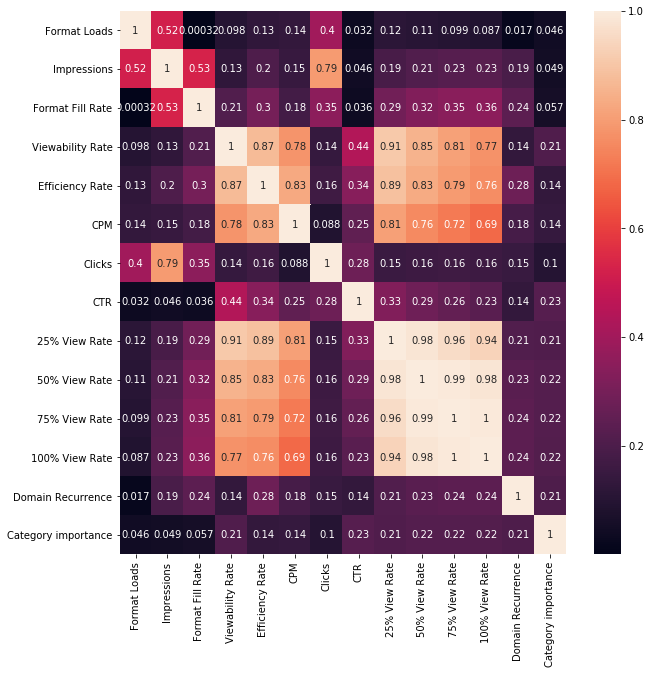

In [48]:
plt.rcParams['figure.figsize']=(10,10)
sns.heatmap(groupby_domains.corr(), annot = True)

- **Only the variables about the View Rate percentages are strongly correlated (more than 90%). I´ll  convert these 4 variables into only one**
- I decide to only keep the 50% View Rate column. The reason is that the mean variation between the 25% View Rate column and the 50% View Rate column is around 8%, and the mean variation between the 25% View Rate column and the 50% View Rate column is around 11%, so the 50% View Rate column gives the best representation to know in which View Rate ranges the domains are

In [50]:
data.drop(['25% View Rate','75% View Rate','100% View Rate'],axis=1, inplace=True)
groupby_domains.drop(['25% View Rate','75% View Rate','100% View Rate'],axis=1, inplace = True)

data.to_csv('Global Report.csv',index=True)
groupby_domains.to_csv('Global groupby_domains.csv', index=False)

In [ ]:
data

# ANALIZING EACH VARIABLE

### Format Loads: traffic generated by each domain

(array([654.,  51.,  20.,   7.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([  30018.89189189,  300941.69616675,  571864.50044162,
         842787.30471648, 1113710.10899134, 1384632.91326621,
        1655555.71754107, 1926478.52181593, 2197401.3260908 ,
        2468324.13036566, 2739246.93464052]),
 <a list of 10 Patch objects>)

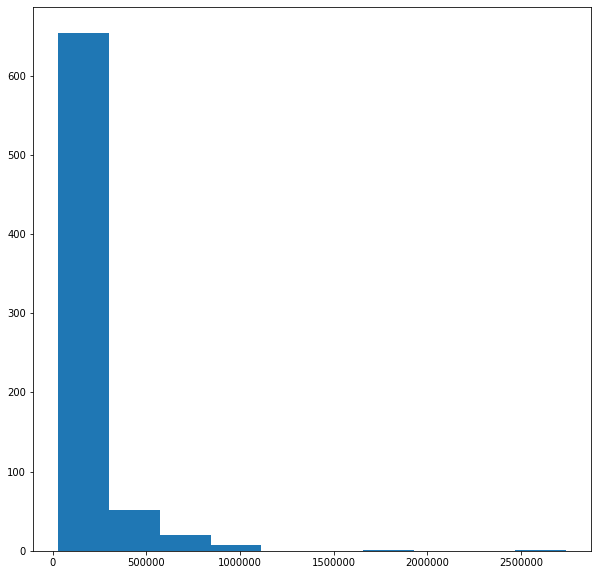

In [53]:
plt.hist(groupby_domains['Format Loads'])

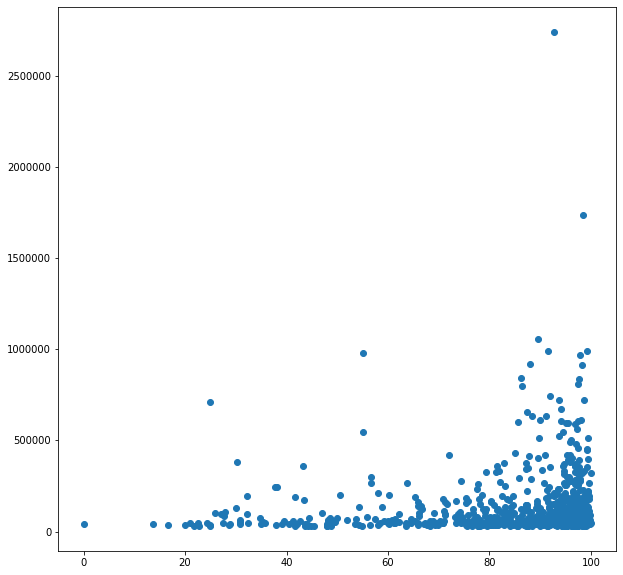

In [55]:
plt.scatter(groupby_domains['Efficiency Rate'], groupby_domains['Format Loads']);

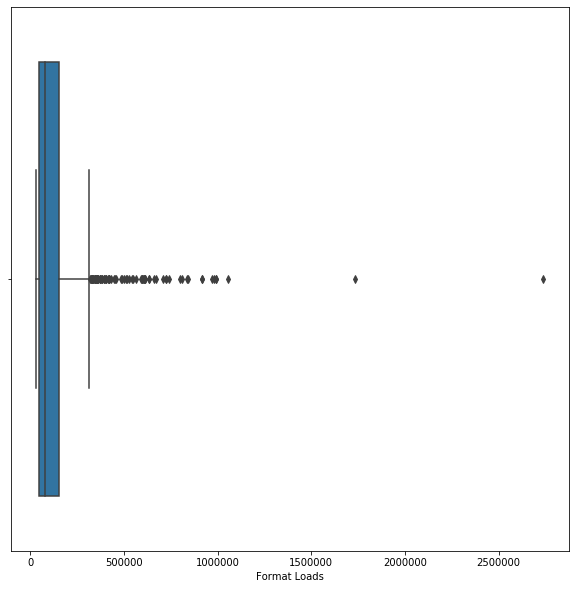

In [56]:
sns.boxplot(groupby_domains['Format Loads'])

In [57]:
groupby_domains['Format Loads'].describe()

count       734.00
mean     143458.38
std      194778.78
min       30018.89
25%       46170.38
50%       80303.37
75%      154939.45
max     2739246.93
Name: Format Loads, dtype: float64

### Impressions: times that the add had appeared to any user in each domain

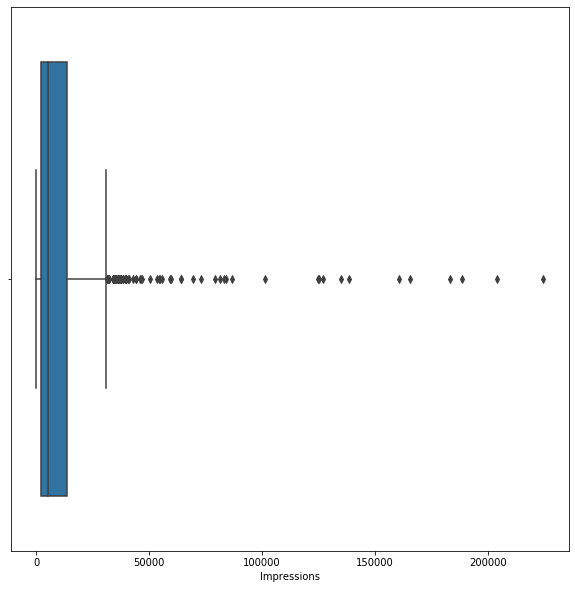

In [58]:
sns.boxplot(groupby_domains['Impressions'])

In [59]:
groupby_domains['Impressions'].describe()

count      734.00
mean     12565.69
std      23076.66
min          0.00
25%       2094.25
50%       5406.15
75%      13774.61
max     224538.68
Name: Impressions, dtype: float64

In [60]:
groupby_domains[groupby_domains['Impressions']<10000] 

,Domain,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category,Category importance
0,memurlar.net,2739246.93,8942.44,0.60,83.80,92.72,1.59,46.82,0.46,67.91,41.80,Health & Wellness,2.08
16,4shared.com,708477.17,9.67,0.00,62.16,24.97,2.18,0.00,0.00,42.70,1.64,Community & Culture,6.61
18,lebanonfiles.com,658081.28,2777.19,0.43,68.72,87.36,1.73,16.36,0.53,68.94,43.44,News & Portals,58.61
21,ask.fm,613391.89,7281.68,1.27,62.22,89.87,1.80,4.36,0.07,69.46,100.00,News & Portals,58.61
25,planet.fr,599581.20,7199.47,14.22,70.93,85.71,1.08,62.93,0.65,56.38,4.10,News & Portals,58.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,beautifulnara.com,30190.34,1788.85,7.90,80.55,98.41,1.60,18.62,0.89,59.36,74.86,News & Portals,58.61
730,peanutimes.com,30099.48,5.47,1.41,39.57,41.58,0.78,0.00,0.00,32.28,39.07,Community & Culture,6.61
731,fruitlab.com,30070.81,355.28,1.60,75.51,87.61,1.88,0.94,0.37,49.81,8.74,Tech & Gaming,1.98
732,naked-science.ru,30055.89,49.61,0.16,93.60,96.51,1.59,0.06,0.06,80.20,4.92,Tech & Gaming,1.98


### Format Fill Rate

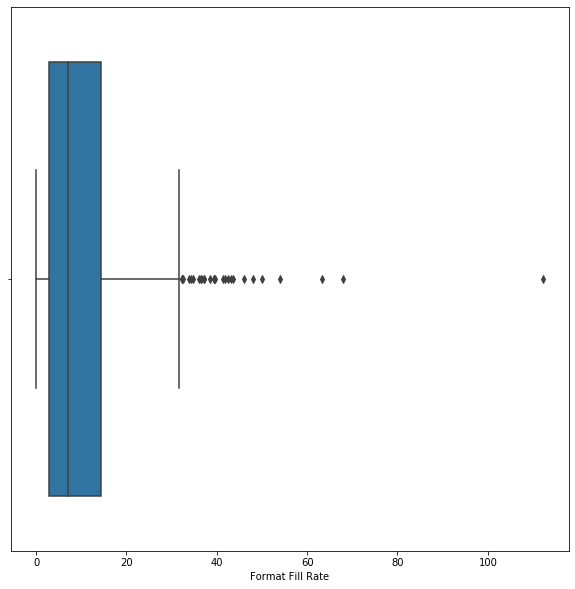

In [61]:
sns.boxplot(groupby_domains['Format Fill Rate'])

In [62]:
groupby_domains['Format Fill Rate'].describe()

count   734.00
mean     10.12
std      10.42
min       0.00
25%       2.87
50%       7.16
75%      14.44
max     112.28
Name: Format Fill Rate, dtype: float64

In [64]:
groupby_domains[groupby_domains['Format Fill Rate']>20]

,Domain,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Domain Recurrence,Category,Category importance
10,laverdadnoticias.com,835287.53,224538.68,27.08,86.63,97.61,1.61,3274.48,1.54,82.29,100.00,News & Portals,58.61
11,correiobraziliense.com.br,809165.13,160481.85,23.23,72.29,97.47,1.66,743.64,0.51,76.16,93.99,News & Portals,58.61
15,huffingtonpost.es,722822.39,125441.87,21.77,87.99,98.57,1.48,1667.39,1.10,74.97,36.34,News & Portals,58.61
20,elcomercio.com,634105.07,55717.99,23.56,80.02,88.42,1.55,394.73,0.61,73.60,19.95,News & Portals,58.61
29,ig.com.br,563212.33,81244.98,39.40,73.01,97.32,1.85,144.69,0.20,83.92,100.00,News & Portals,58.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,boxun.com,30860.39,6619.30,20.89,78.18,97.54,1.68,19.64,0.31,75.02,100.00,News & Portals,58.61
719,thebl.com,30670.67,12351.34,23.63,55.56,63.56,1.05,117.85,0.51,44.30,26.23,News & Portals,58.61
720,champion.gg,30404.75,8943.09,31.12,78.59,98.98,1.69,5.26,0.06,85.35,84.15,Tech & Gaming,1.98
721,nacion.com,30391.06,6465.09,20.77,73.42,95.19,1.70,25.63,0.55,78.22,99.73,News & Portals,58.61


In [65]:
data[data['Format Fill Rate']>100].shape

(894, 13)

There are some cases where the Format Fill Rate can be more than 100%, that means more Impressions than Format Loads. It´s not a mistake, it can happen for example with agressive campaigns

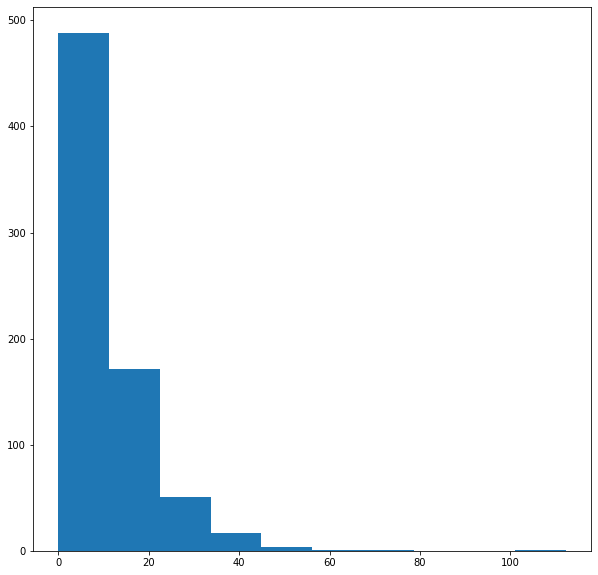

In [66]:
plt.hist(groupby_domains['Format Fill Rate']);

### UNDERSTANDING THE DATA WITH GRAPHS

### General shape of the Format Loads and Impressions over the 3 months:

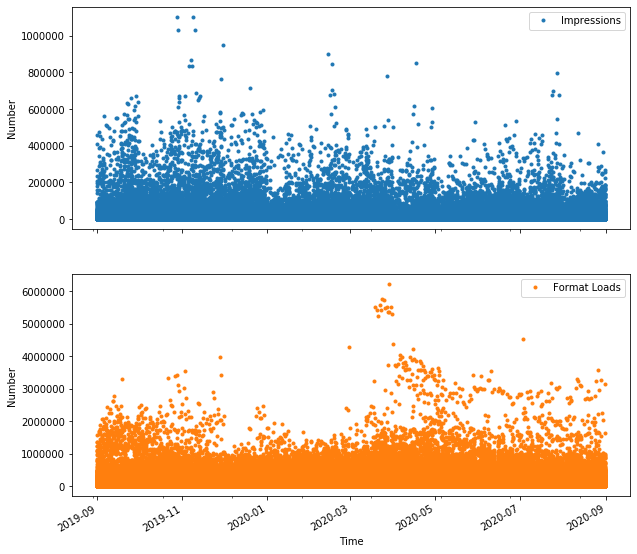

In [68]:
col_graf = ['Impressions', 'Format Loads'] 
ejes = data[col_graf].plot(marker='.', linestyle='None',figsize=(10,10),subplots=True)
for eje in ejes:
  eje.set_ylabel('Number')

### Distribution of the categories

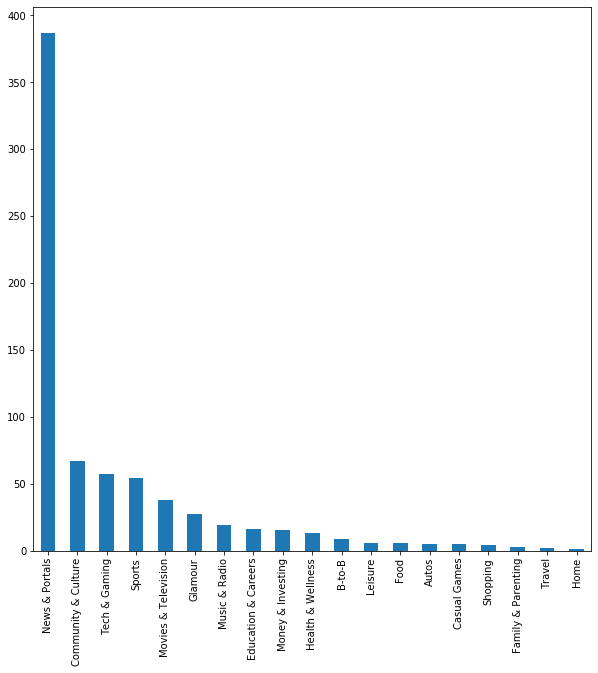

In [69]:
categories_distribution=groupby_domains['Category'].value_counts()
categories_distribution.plot(kind='bar');

### Impressions evolution through the three months

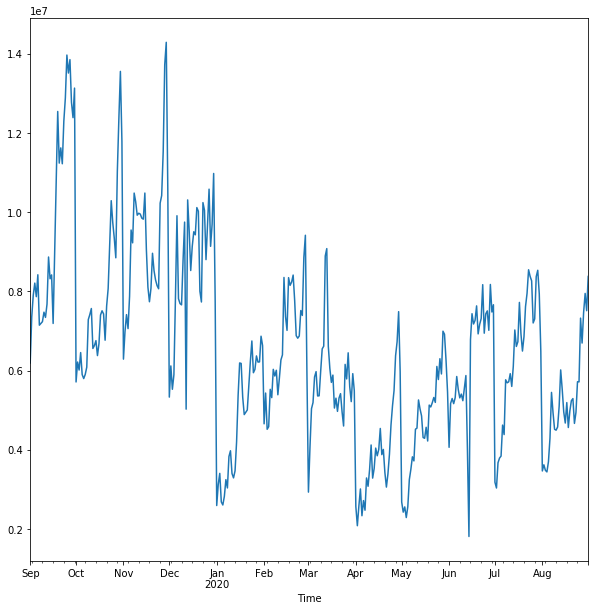

In [70]:
data.groupby(data.index)['Impressions'].sum().plot(kind='line', rot = 0)

### Number of recurrent Domains

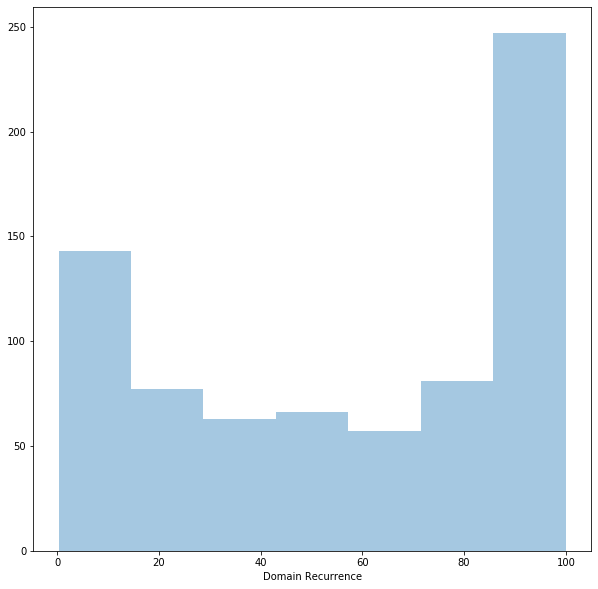

In [71]:
sns.distplot(groupby_domains['Domain Recurrence'], kde = False);

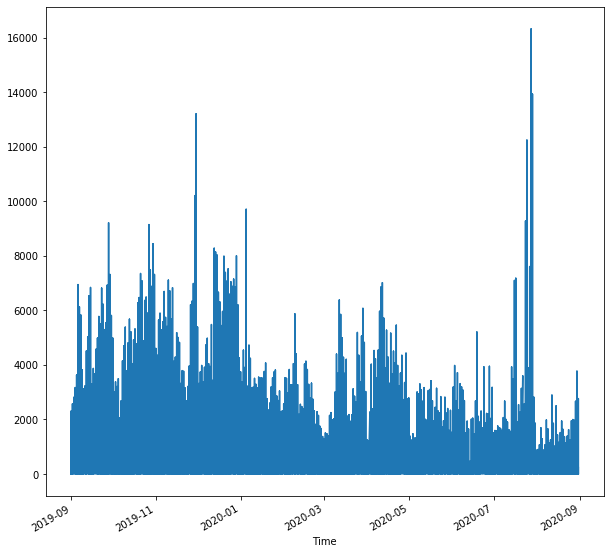

In [72]:
plt.rcParams['figure.figsize']=(10,10)
data.Clicks.plot(kind= 'line')

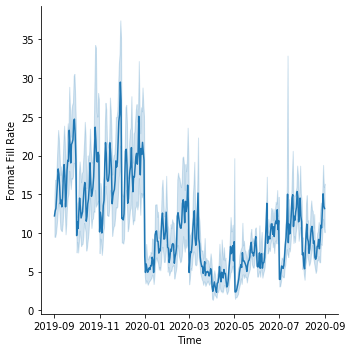

In [74]:
ffr_bycategories = pd.DataFrame(data.groupby(['Time', 'Category'])['Format Fill Rate'].mean()).reset_index()
sns.relplot(x="Time", y='Format Fill Rate', kind="line", data=ffr_bycategories)